In [24]:
import sys
sys.path.append('../scripts')

import os
import json
import pickle

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

from data_analysis import (get_best_hpo_configs_averaged_across_runs, get_best_epoch_across_runs, get_hpo_analysis, 
get_controls, get_best_epoch_across_locofolds, get_run_history, get_average_best_hpo_configs_averaged_across_runs)

### Define paths for relevant directories

In [25]:
controls_filepath = r"..\data\controls.json"
train_val_split_path = r"..\data\ionic_conductivity_database_11022023_train_val_test_splits2\classification\lococv"
atomistic_feature_path = r"..\data\atomistic_features_11022023.pkl"
atomistic_results_path =r"..\data\atomistic_lococv_results.pkl"

### Plot results from leave-one-cluster-out cross validation

Best epoch for structure_megnet_site_feature_level_1_2019_4_1_formation_energy_2 for val_pr_auc metric: 173
Best epoch for structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy_2 for val_pr_auc metric: 177
Best epoch for structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy_2 for val_pr_auc metric: 183
Best epoch for structure_simplified_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy_2 for val_pr_auc metric: 243
The average value of val_pr_auc for the best average epoch of AS-CAMN is: 0.8550668224692345
The standard deviation value of val_pr_auc for the best average epoch of AS-CAMN is: 0.14556022082275422
The average maximum value of val_pr_auc of AS-CAMN is: 0.89807512819767
The standard deviation value of the maximum value of val_pr_auc of AS-CAMN is: 0.131879100887404
The average value of val_pr_auc for the best average epoch of AS-CAN is: 0.8314981240034104
The standard deviation value of val_pr_auc for the best average epoch of AS

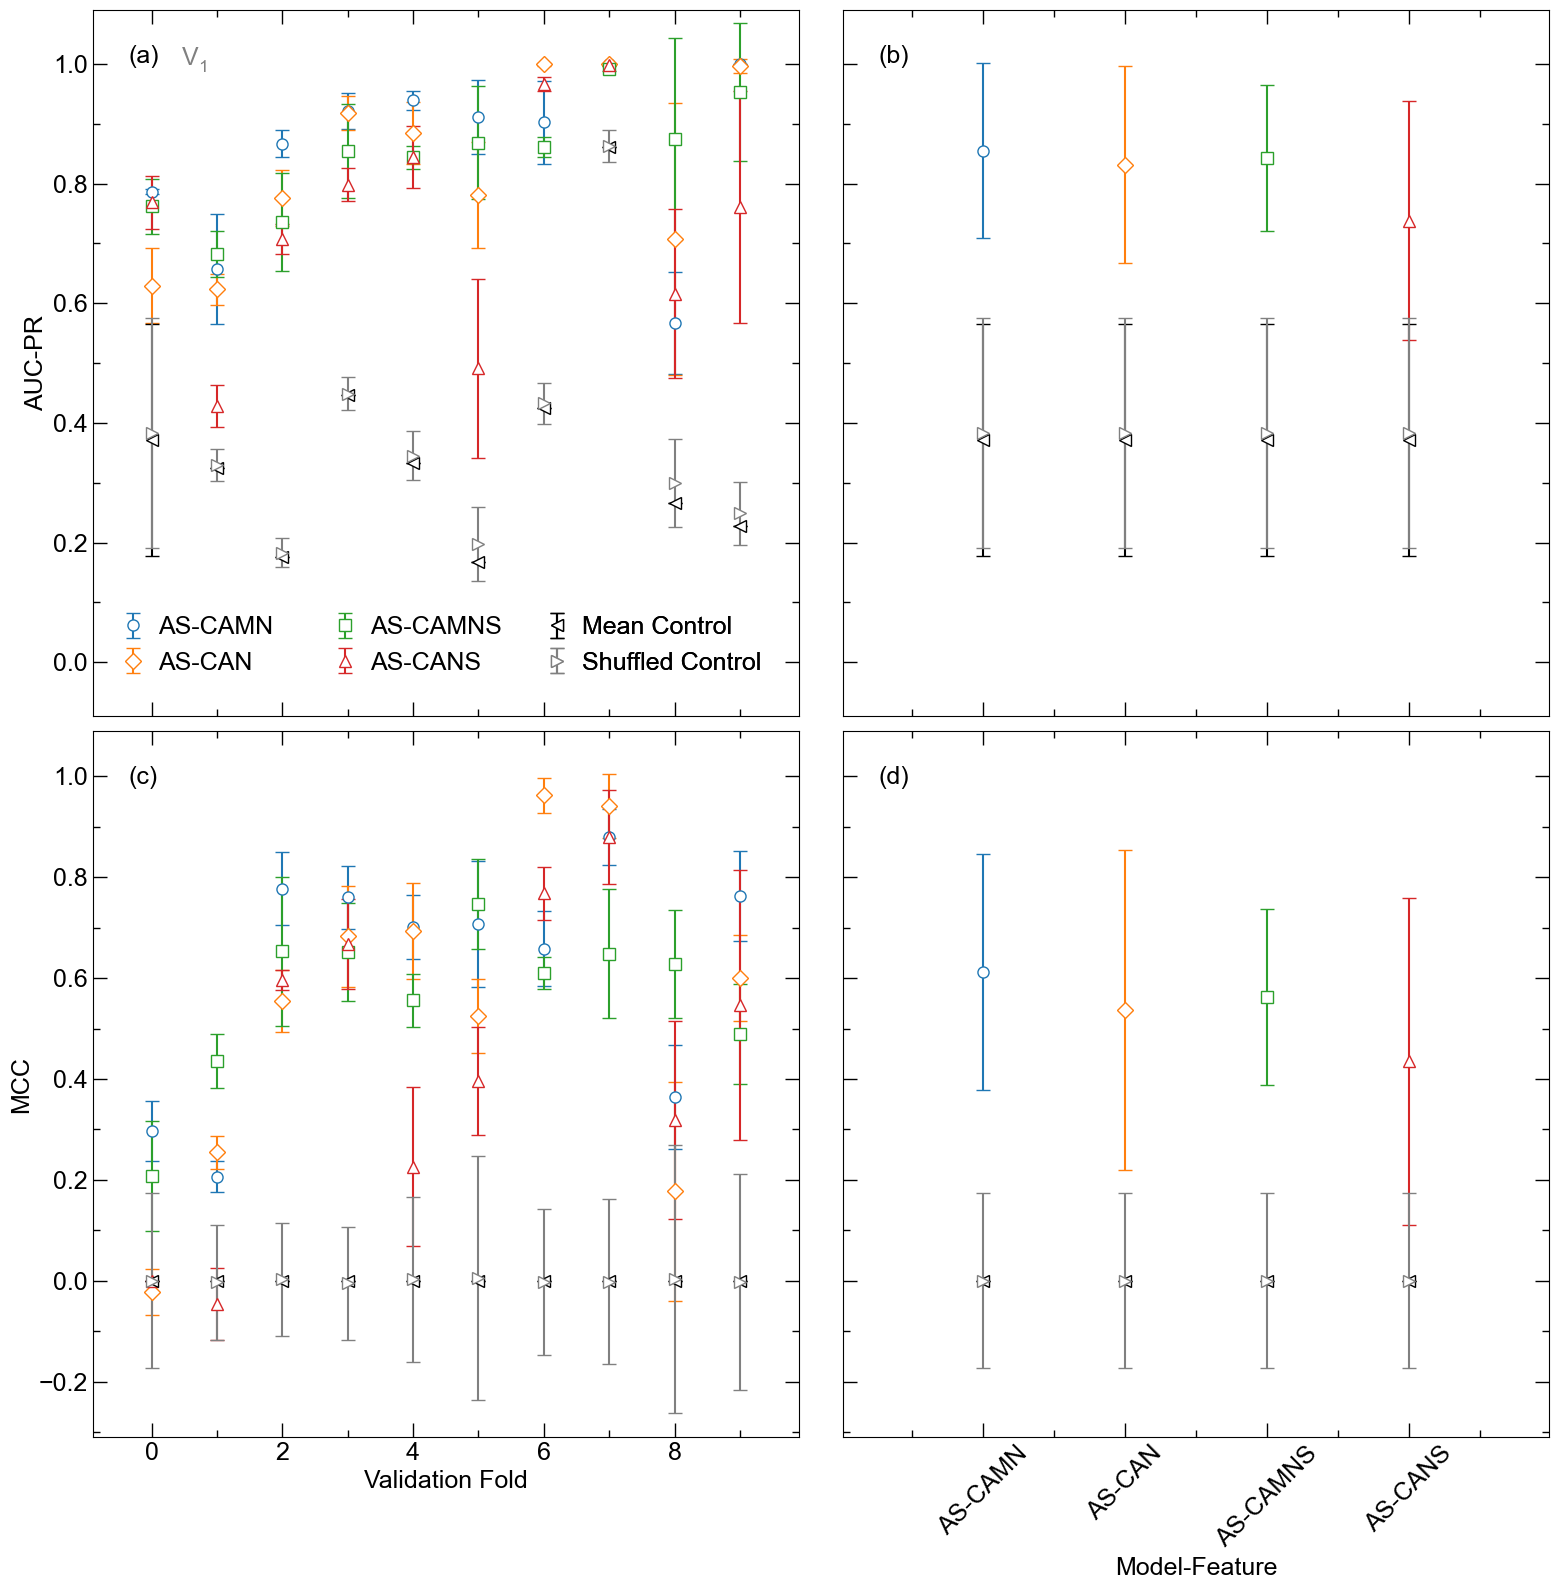

In [22]:
plt.rcParams['font.family'] = 'Arial'
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
ax1 = axes[0, 0]
ax1.set_xlabel('Validation Fold', fontsize=18)
ax1.set_ylabel('AUC-PR', fontsize=18)
ax1.set_ylim([-0.09, 1.09])
ax1.set_xlim([-0.9, 9.9])
ax1.text(0.05, 0.95, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)
ax1.text(0.125, 0.95, r'V$_{1}$', fontsize=18, color='grey', verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)
ax1.set_aspect(np.diff(ax1.get_xlim()) / np.diff(ax1.get_ylim()))

with open(atomistic_results_path, 'rb') as f:
    atomistic_results = pickle.load(f)
    
features = ['structure_megnet_site_feature_level_1_2019_4_1_formation_energy_2', 'structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy_2',  'structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy_2', 'structure_simplified_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy_2']

labels = [
    "AS-CAMN",
    "AS-CAN",
    "AS-CAMNS",
    "AS-CANS",
]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "black", "grey", "tab:purple"]
markers = ['o', 'D', 's', '^', '<', '>', 'v']
config_metric = "val_pr_auc"
validation_type = "lococv"
plot_metric = "val_pr_auc"
atomistic_max_metric = {}
mean_control_avg = {}
mean_control_std = {}
shuffled_control_avg = {}
shuffled_control_std = {}

for fold in os.listdir(train_val_split_path):
    fold_num = int(fold.split("_")[-1])
    mean_control_avg[fold_num], mean_control_std[fold_num], shuffled_control_avg[fold_num], shuffled_control_std[fold_num] = get_controls(controls_filepath=controls_filepath, 
                                                                                                                          validation_type=validation_type, 
                                                                                                                          fold=fold_num, 
                                                                                                                          metric=plot_metric)
    atomistic_max_metric[fold_num] = max(atomistic_results[fold], key=lambda x: x['val_pr_auc'])[plot_metric]
    
for i, feature in enumerate(features):
    color = colors[i]
    label = labels[i]
    averaged_metric_values_best_epoch = {}
    averaged_best_metric_values = {}
    feature_best_metric_values = []
    best_average_epoch = get_best_epoch_across_locofolds(data_dir=train_val_split_path, feature=feature, metric=config_metric, top_n=1, min_epoch=30)
    print(f'Best epoch for {feature} for {config_metric} metric: {best_average_epoch}')
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_path = os.path.join(train_val_split_path, fold)
        data_dir = os.path.join(fold_path, feature)
        top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
        fold_metric_values_best_epoch = []
        fold_best_metric_values = []
        for config in top_configs:
            config_dir = os.path.join(data_dir, config)
            for run_dir in os.listdir(config_dir):
                history_path = os.path.join(config_dir, run_dir, "history.pkl")
                run_data = get_run_history(history_path)
                fold_metric_values_best_epoch.append(run_data.loc[best_average_epoch, plot_metric])
                fold_best_metric_values.append(max(run_data[plot_metric]))
                
        fold_avg_metric_value_best_epoch = np.mean(fold_metric_values_best_epoch)
        fold_std_metric_value_best_epoch = np.std(fold_metric_values_best_epoch)
        fold_avg_best_metric_value = np.mean(fold_best_metric_values)
        fold_std_best_metric_value = np.std(fold_best_metric_values)
        
        averaged_metric_values_best_epoch[fold_num] = {'mean': fold_avg_metric_value_best_epoch, 'std': fold_std_metric_value_best_epoch}
        averaged_best_metric_values[fold_num] = {'mean': fold_avg_best_metric_value, 'std': fold_std_best_metric_value}

    fold_nums = sorted(averaged_best_metric_values.keys())
    fold_means_best_epoch = [averaged_metric_values_best_epoch[fold]['mean'] for fold in fold_nums]
    fold_stds_best_epoch = [averaged_metric_values_best_epoch[fold]['std'] for fold in fold_nums]
    fold_means_best_value = [averaged_best_metric_values[fold]['mean'] for fold in fold_nums]
    fold_stds_best_value = [averaged_best_metric_values[fold]['std'] for fold in fold_nums]
    
    ax1.errorbar(fold_nums, 
                fold_means_best_epoch, 
                yerr=fold_stds_best_epoch, 
                marker=markers[i],
                linestyle='',
                color=color,
                markersize=8, 
                markerfacecolor='w',
                capsize=5,
                label=label)
    """
    plt.errorbar(fold_nums, 
             fold_means_best_value, 
             yerr=fold_stds_best_value, 
             fmt=markers[i],
             color=color,
             markersize=8, 
             markerfacecolor=color,
             capsize=5,
             label='')
    """

ax1.errorbar(range(10), 
            [mean_control_avg[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
            yerr=[mean_control_std[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
            marker=markers[4], 
            linestyle='',
            color=colors[4], 
            markersize=8, 
            markerfacecolor='w',
            capsize=5,
            label='Mean Control')

ax1.errorbar(range(10), 
            [shuffled_control_avg[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
            yerr=[shuffled_control_std[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
            marker=markers[5], 
            linestyle='',
            color=colors[5],
            markersize=8, 
            markerfacecolor='w',
            capsize=5,
            label='Shuffled Control')

ax1.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

handles, labels = ax1.get_legend_handles_labels()

custom_handles = []
for handle, label in zip(handles, labels):
    if label == 'LR-Atomistic':
        custom_handle = Line2D([0], [0], color=handle[0].get_color(), marker=handle[0].get_marker(), linestyle='', markerfacecolor='w', markersize=8)
        custom_handles.append(custom_handle)
    else:
        custom_handles.append(handle)

order = [0, 1, 2, 3, 4, 5] 

group1_handles = [custom_handles[idx] for idx in order[:2]]
group2_handles = [custom_handles[idx] for idx in order[2:4]]
group3_handles = [custom_handles[idx] for idx in order[4:]]

group1_labels = [labels[idx] for idx in order[:2]]
group2_labels = [labels[idx] for idx in order[2:4]]
group3_labels = [labels[idx] for idx in order[4:]]

legend1 = ax1.legend(group1_handles, group1_labels, loc='center left', bbox_to_anchor=(-0.01, 0.1), fontsize=18, frameon=False, handletextpad=0.01)
legend2 = ax1.legend(group2_handles, group2_labels, loc='center left', bbox_to_anchor=(0.29, 0.1), fontsize=18, frameon=False, handletextpad=0.01)
legend3 = ax1.legend(group3_handles, group3_labels, loc='center left', bbox_to_anchor=(0.59, 0.1), fontsize=18, frameon=False, handletextpad=0.01)

ax1.add_artist(legend1)
ax1.add_artist(legend2)
ax1.add_artist(legend3)

ax1.set_xlabel('')
ax1.set_xticklabels([])

plt.rcParams['font.family'] = 'Arial'
ax2 = axes[1, 0]
plt.rcParams['font.family'] = 'Arial'
ax2.set_xlabel('Validation Fold', fontsize=18)
ax2.set_ylabel('MCC', fontsize=18)
ax2.set_ylim([-0.31, 1.09])
ax2.set_xlim([-0.9, 9.9])
ax2.text(0.05, 0.95, '(c)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes)
ax2.set_aspect(np.diff(ax2.get_xlim()) / np.diff(ax2.get_ylim()))

plot_metric = "val_mcc"
atomistic_max_metric = {}
mean_control_avg = {}
mean_control_std = {}
shuffled_control_avg = {}
shuffled_control_std = {}

for fold in os.listdir(train_val_split_path):
    fold_num = int(fold.split("_")[-1])
    mean_control_avg[fold_num], mean_control_std[fold_num], shuffled_control_avg[fold_num], shuffled_control_std[fold_num] = get_controls(controls_filepath=controls_filepath, 
                                                                                                                          validation_type=validation_type, 
                                                                                                                          fold=fold_num, 
                                                                                                                          metric=plot_metric)
    atomistic_max_metric[fold_num] = max(atomistic_results[fold], key=lambda x: x['val_pr_auc'])[plot_metric]

for i, feature in enumerate(features):
    color = colors[i]
    label = labels[i]
    averaged_metric_values_best_epoch = {}
    averaged_best_metric_values = {}
    feature_best_metric_values = []
    best_average_epoch = get_best_epoch_across_locofolds(data_dir=train_val_split_path, feature=feature, metric=config_metric, top_n=1, min_epoch=30)
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_path = os.path.join(train_val_split_path, fold)
        data_dir = os.path.join(fold_path, feature)
        top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
        fold_metric_values_best_epoch = []
        fold_best_metric_values = []
        for config in top_configs:
            config_dir = os.path.join(data_dir, config)
            for run_dir in os.listdir(config_dir):
                history_path = os.path.join(config_dir, run_dir, "history.pkl")
                run_data = get_run_history(history_path)
                fold_metric_values_best_epoch.append(run_data.loc[best_average_epoch, plot_metric])
                fold_best_metric_values.append(max(run_data[plot_metric]))
                
        fold_avg_metric_value_best_epoch = np.mean(fold_metric_values_best_epoch)
        fold_std_metric_value_best_epoch = np.std(fold_metric_values_best_epoch)
        fold_avg_best_metric_value = np.mean(fold_best_metric_values)
        fold_std_best_metric_value = np.std(fold_best_metric_values)
        
        averaged_metric_values_best_epoch[fold_num] = {'mean': fold_avg_metric_value_best_epoch, 'std': fold_std_metric_value_best_epoch}
        averaged_best_metric_values[fold_num] = {'mean': fold_avg_best_metric_value, 'std': fold_std_best_metric_value}

    fold_nums = sorted(averaged_best_metric_values.keys())
    fold_means_best_epoch = [averaged_metric_values_best_epoch[fold]['mean'] for fold in fold_nums]
    fold_stds_best_epoch = [averaged_metric_values_best_epoch[fold]['std'] for fold in fold_nums]
    fold_means_best_value = [averaged_best_metric_values[fold]['mean'] for fold in fold_nums]
    fold_stds_best_value = [averaged_best_metric_values[fold]['std'] for fold in fold_nums]
    
    ax2.errorbar(fold_nums, 
             fold_means_best_epoch, 
             yerr=fold_stds_best_epoch, 
             fmt=markers[i],
             color=color,
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label=label)
    
ax2.errorbar(range(10), 
             [mean_control_avg[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
             yerr=[mean_control_std[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
             fmt=markers[4], 
             color=colors[4], 
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Mean Control')
ax2.errorbar(range(10), [shuffled_control_avg[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
             yerr=[shuffled_control_std[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
             fmt=markers[5], 
             color=colors[5],
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Shuffled Control')

ax2.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax2.minorticks_on()
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.rcParams['font.family'] = 'Arial'
ax3 = axes[0, 1]
plt.rcParams['font.family'] = 'Arial'
ax3.set_xlabel('Model-Feature', fontsize=18)
ax3.set_ylabel('AUC-PR', fontsize=18)
ax3.set_ylim([-0.09, 1.09])
ax3.set_xlim([-0.99, 3.99])
ax3.text(0.05, 0.95, '(b)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes)
ax3.set_aspect(np.diff(ax3.get_xlim()) / np.diff(ax3.get_ylim()))

x_coords = np.arange(len(labels))    

plot_metric = "val_pr_auc"

shuffled_control_avg = {}
shuffled_control_std = {}

mean_control_avg, mean_control_std, shuffled_control_avg, shuffled_control_std = get_controls(controls_filepath=controls_filepath, 
                                                                                              validation_type=validation_type, 
                                                                                              metric=plot_metric,
                                                                                              fold=None)

for i, feature in enumerate(features):
    color = colors[i]
    label = labels[i]
    feature_best_metric_values_at_best_epoch = []
    feature_best_metric_values_during_run = []
    best_average_epoch = get_best_epoch_across_locofolds(data_dir=train_val_split_path, feature=feature, metric=config_metric, top_n=1, min_epoch=30)
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_path = os.path.join(train_val_split_path, fold)
        data_dir = os.path.join(fold_path, feature)
        top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
        fold_best_metric_values = []
        for config in top_configs:
            config_dir = os.path.join(data_dir, config)
            for run_dir in os.listdir(config_dir):
                history_path = os.path.join(config_dir, run_dir, "history.pkl")
                run_data = get_run_history(history_path)
                feature_best_metric_values_at_best_epoch.append(run_data.loc[best_average_epoch, plot_metric])
                feature_best_metric_values_during_run.append(max(run_data[plot_metric]))

    feature_best_metric_values_at_best_epoch_mean = np.mean(feature_best_metric_values_at_best_epoch)
    feature_best_metric_values_at_best_epoch_std = np.std(feature_best_metric_values_at_best_epoch)
    feature_best_metric_values_during_run_mean = np.mean(feature_best_metric_values_during_run)
    feature_best_metric_values_during_run_std = np.std(feature_best_metric_values_during_run)

    print(f"The average value of {plot_metric} for the best average epoch of {label} is: {feature_best_metric_values_at_best_epoch_mean}")
    print(f"The standard deviation value of {plot_metric} for the best average epoch of {label} is: {feature_best_metric_values_at_best_epoch_std}")
    print(f"The average maximum value of {plot_metric} of {label} is: {feature_best_metric_values_during_run_mean}")
    print(f"The standard deviation value of the maximum value of {plot_metric} of {label} is: {feature_best_metric_values_during_run_std}")
    
    ax3.errorbar(x_coords[i], 
                 feature_best_metric_values_at_best_epoch_mean, 
                 yerr=feature_best_metric_values_at_best_epoch_std, 
                 fmt=markers[i],
                 color=color,
                 markersize=8, 
                 markerfacecolor='w',
                 capsize=5,
                 label=label
                )

ax3.errorbar(x_coords[0:4],
             y=np.full(len(labels[0:4]), mean_control_avg),
             yerr=np.full(len(labels[0:4]), mean_control_std), 
             fmt=markers[4], 
             color='black', 
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Mean Control')
ax3.errorbar(x_coords[0:4],
             y=np.full(len(labels[0:4]), shuffled_control_avg),
             yerr=np.full(len(labels[0:4]), shuffled_control_std), 
             fmt=markers[5], 
             color='gray',
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Shuffled Control')

ax3.set_xticks(x_coords[0:4])
ax3.set_xticklabels(labels[0:4], rotation=45, ha='center')
ax3.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax3.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax3.minorticks_on()
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax3.set_xlabel('')
ax3.set_xticklabels([])
ax3.set_ylabel('')
ax3.set_yticklabels([])

plt.rcParams['font.family'] = 'Arial'
ax4 = axes[1, 1]
plt.rcParams['font.family'] = 'Arial'
ax4.set_xlabel('Model-Feature', fontsize=18)
ax4.set_ylabel('MCC', fontsize=18)
ax4.set_ylim([-0.31, 1.09])
ax4.set_xlim([-0.99, 3.99])
ax4.text(0.05, 0.95, '(d)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax4.transAxes)
ax4.set_aspect(np.diff(ax4.get_xlim()) / np.diff(ax4.get_ylim()))

plot_metric = "val_mcc"

mean_control_avg = {}
mean_control_std = {}
shuffled_control_avg = {}
shuffled_control_std = {}

mean_control_avg, mean_control_std, shuffled_control_avg, shuffled_control_std = get_controls(controls_filepath=controls_filepath, 
                                                                                              validation_type=validation_type, 
                                                                                              metric=plot_metric,
                                                                                              fold=None)

for i, feature in enumerate(features):
    color = colors[i]
    label = labels[i]
    feature_best_metric_values_at_best_epoch = []
    feature_best_metric_values_during_run = []
    best_average_epoch = get_best_epoch_across_locofolds(data_dir=train_val_split_path, feature=feature, metric=config_metric, top_n=1, min_epoch=30)
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_path = os.path.join(train_val_split_path, fold)
        data_dir = os.path.join(fold_path, feature)
        top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
        fold_best_metric_values = []
        for config in top_configs:
            config_dir = os.path.join(data_dir, config)
            for run_dir in os.listdir(config_dir):
                history_path = os.path.join(config_dir, run_dir, "history.pkl")
                run_data = get_run_history(history_path)
                feature_best_metric_values_at_best_epoch.append(run_data.loc[best_average_epoch, plot_metric])
                feature_best_metric_values_during_run.append(max(run_data[plot_metric]))

    feature_best_metric_values_at_best_epoch_mean = np.mean(feature_best_metric_values_at_best_epoch)
    feature_best_metric_values_at_best_epoch_std = np.std(feature_best_metric_values_at_best_epoch)
    feature_best_metric_values_during_run_mean = np.mean(feature_best_metric_values_during_run)
    feature_best_metric_values_during_run_std = np.std(feature_best_metric_values_during_run)

    print(f"The average value of {plot_metric} for the best average epoch of {label} is: {feature_best_metric_values_at_best_epoch_mean}")
    print(f"The standard deviation value of {plot_metric} for the best average epoch of {label} is: {feature_best_metric_values_at_best_epoch_std}")
    print(f"The average maximum value of {plot_metric} of {label} is: {feature_best_metric_values_during_run_mean}")
    print(f"The standard deviation value of the maximum value of {plot_metric} of {label} is: {feature_best_metric_values_during_run_std}")
    
    ax4.errorbar(x_coords[i], 
                 feature_best_metric_values_at_best_epoch_mean, 
                 yerr=feature_best_metric_values_at_best_epoch_std, 
                 fmt=markers[i],
                 color=color,
                 markersize=8, 
                 markerfacecolor='w',
                 capsize=5,
                 label=label
                )

ax4.errorbar(x=x_coords[0:4],
             y=np.full(len(labels[0:4]), mean_control_avg),
             yerr=np.full(len(labels[0:4]), mean_control_std), 
             fmt=markers[4], 
             color='black', 
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Mean Control')

ax4.errorbar(x=x_coords[0:4],
             y=np.full(len(labels[0:4]), shuffled_control_avg),
             yerr=np.full(len(labels[0:4]), shuffled_control_std), 
             fmt=markers[5], 
             color='gray',
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Shuffled Control')

ax4.set_xticks(x_coords[0:4])
ax4.set_xticklabels(labels[0:4], rotation=45, ha='center')
ax4.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax4.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax4.minorticks_on()
ax4.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax4.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax4.set_ylabel('')
ax4.set_yticklabels([])

plt.tight_layout()
plt.savefig('../figures/structural_representation.png', dpi=450, bbox_inches='tight')
plt.show()

C:\Users\mchaf\AppData\Local\Temp\ipykernel_27544\2656216037.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


Best epoch for structure_megnet_site_feature_level_0_2019_4_1_formation_energy_2 for val_pr_auc metric: 96
Best epoch for structure_megnet_site_feature_level_1_2019_4_1_formation_energy_2 for val_pr_auc metric: 173
Best epoch for structure_megnet_site_feature_level_2_2019_4_1_formation_energy_2 for val_pr_auc metric: 151
Best epoch for structure_megnet_site_feature_level_3_2019_4_1_formation_energy_2 for val_pr_auc metric: 177
The average value of val_pr_auc for the best average epoch of AS-V$_{0}$ is: 0.8461831191182136
The standard deviation value of val_pr_auc for the best average epoch of AS-V$_{0}$ is: 0.17302898730956234
The average maximum value of val_pr_auc of AS-V$_{0}$ is: 0.892333316206932
The standard deviation value of the maximum value of val_pr_auc of AS-V$_{0}$ is: 0.1371892905107833
The average value of val_pr_auc for the best average epoch of AS-V$_{1}$ is: 0.8550668224692345
The standard deviation value of val_pr_auc for the best average epoch of AS-V$_{1}$ is: 0.14

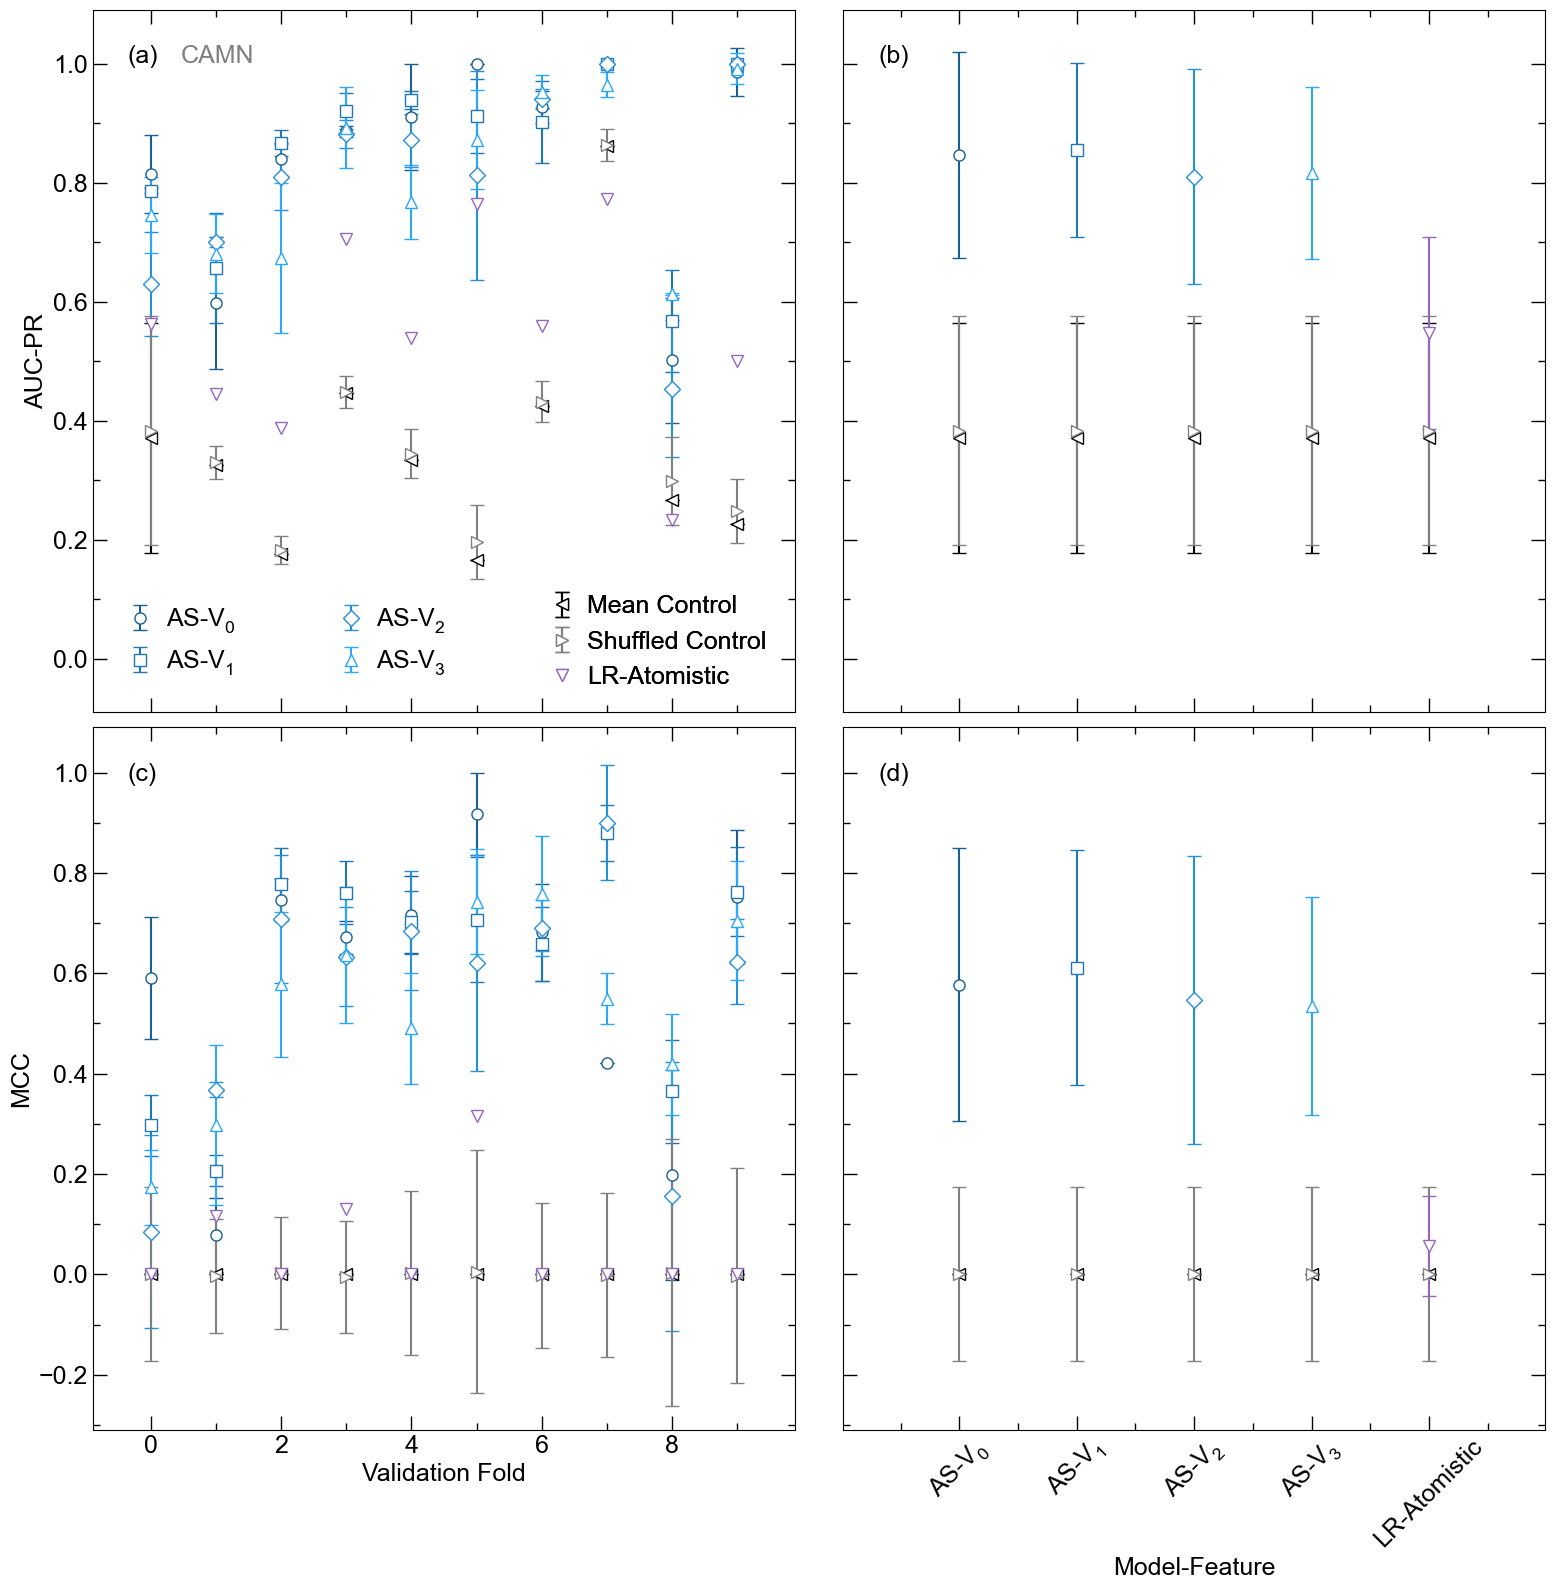

In [23]:
plt.rcParams['font.family'] = 'Arial'
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
#plt.subplots_adjust(wspace=None, hspace=None)
plt.rcParams['font.family'] = 'Arial'
ax1 = axes[0, 0]
ax1.set_xlabel('Validation Fold', fontsize=18)
ax1.set_ylabel('AUC-PR', fontsize=18)
ax1.set_ylim([-0.09, 1.09])
ax1.set_xlim([-0.9, 9.9])
ax1.text(0.05, 0.95, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)
ax1.text(0.125, 0.95, 'CAMN', fontsize=18, color='grey', verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)
ax1.set_aspect(np.diff(ax1.get_xlim()) / np.diff(ax1.get_ylim()))

with open(atomistic_results_path, 'rb') as f:
    atomistic_results = pickle.load(f)

features = ['structure_megnet_site_feature_level_0_2019_4_1_formation_energy_2', 'structure_megnet_site_feature_level_1_2019_4_1_formation_energy_2', 'structure_megnet_site_feature_level_2_2019_4_1_formation_energy_2', 'structure_megnet_site_feature_level_3_2019_4_1_formation_energy_2']

labels = [
    r'AS-V$_{0}$',
    r'AS-V$_{1}$',
    r'AS-V$_{2}$',
    r'AS-V$_{3}$',
]

colormap = plt.cm.get_cmap('tab10')
base_color = colormap.colors[0]

colors = [
    tuple(min(1.0, c * 0.8) for c in base_color),
    base_color,
    tuple(min(1.0, c * 1.2) for c in base_color),
    tuple(min(1.0, c * 1.4) for c in base_color),
    'black',
    'grey', 
    'tab:purple'
]

markers = ['o', 's', 'D', '^', '<', '>', 'v']
config_metric = "val_pr_auc"
validation_type = "lococv"
plot_metric = "val_pr_auc"
atomistic_max_metric = {}
mean_control_avg = {}
mean_control_std = {}
shuffled_control_avg = {}
shuffled_control_std = {}

for fold in os.listdir(train_val_split_path):
    fold_num = int(fold.split("_")[-1])
    mean_control_avg[fold_num], mean_control_std[fold_num], shuffled_control_avg[fold_num], shuffled_control_std[fold_num] = get_controls(controls_filepath=controls_filepath, 
                                                                                                                          validation_type=validation_type, 
                                                                                                                          fold=fold_num, 
                                                                                                                          metric=plot_metric)
    atomistic_max_metric[fold_num] = max(atomistic_results[fold], key=lambda x: x['val_pr_auc'])[plot_metric]
    
for i, feature in enumerate(features):
    color = colors[i]
    label = labels[i]
    averaged_metric_values_best_epoch = {}
    averaged_best_metric_values = {}
    feature_best_metric_values = []
    best_average_epoch = get_best_epoch_across_locofolds(data_dir=train_val_split_path, feature=feature, metric=config_metric, top_n=1, min_epoch=30)
    print(f'Best epoch for {feature} for {config_metric} metric: {best_average_epoch}')
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_path = os.path.join(train_val_split_path, fold)
        data_dir = os.path.join(fold_path, feature)
        top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
        fold_metric_values_best_epoch = []
        fold_best_metric_values = []
        for config in top_configs:
            config_dir = os.path.join(data_dir, config)
            for run_dir in os.listdir(config_dir):
                history_path = os.path.join(config_dir, run_dir, "history.pkl")
                run_data = get_run_history(history_path)
                fold_metric_values_best_epoch.append(run_data.loc[best_average_epoch, plot_metric])
                fold_best_metric_values.append(max(run_data[plot_metric]))
                
        fold_avg_metric_value_best_epoch = np.mean(fold_metric_values_best_epoch)
        fold_std_metric_value_best_epoch = np.std(fold_metric_values_best_epoch)
        fold_avg_best_metric_value = np.mean(fold_best_metric_values)
        fold_std_best_metric_value = np.std(fold_best_metric_values)
        
        averaged_metric_values_best_epoch[fold_num] = {'mean': fold_avg_metric_value_best_epoch, 'std': fold_std_metric_value_best_epoch}
        averaged_best_metric_values[fold_num] = {'mean': fold_avg_best_metric_value, 'std': fold_std_best_metric_value}

    fold_nums = sorted(averaged_best_metric_values.keys())
    fold_means_best_epoch = [averaged_metric_values_best_epoch[fold]['mean'] for fold in fold_nums]
    fold_stds_best_epoch = [averaged_metric_values_best_epoch[fold]['std'] for fold in fold_nums]
    fold_means_best_value = [averaged_best_metric_values[fold]['mean'] for fold in fold_nums]
    fold_stds_best_value = [averaged_best_metric_values[fold]['std'] for fold in fold_nums]
    
    ax1.errorbar(fold_nums, 
                fold_means_best_epoch, 
                yerr=fold_stds_best_epoch, 
                marker=markers[i],
                linestyle='',
                color=color,
                markersize=8, 
                markerfacecolor='w',
                capsize=5,
                label=label)
    """
    plt.errorbar(fold_nums, 
             fold_means_best_value, 
             yerr=fold_stds_best_value, 
             fmt=markers[i],
             color=color,
             markersize=8, 
             markerfacecolor=color,
             capsize=5,
             label='')
    """

ax1.errorbar(range(10), 
            [mean_control_avg[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
            yerr=[mean_control_std[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
            marker=markers[4], 
            linestyle='',
            color=colors[4], 
            markersize=8, 
            markerfacecolor='w',
            capsize=5,
            label='Mean Control')

ax1.errorbar(range(10), 
            [shuffled_control_avg[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
            yerr=[shuffled_control_std[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
            marker=markers[5], 
            linestyle='',
            color=colors[5],
            markersize=8, 
            markerfacecolor='w',
            capsize=5,
            label='Shuffled Control')

ax1.errorbar(range(10), 
            [atomistic_max_metric[fold_num] for fold_num in range(10)],
            yerr=[0 for _ in range(10)],  # No error bars
            fmt=markers[6],
            linestyle='',
            color=colors[6],
            markersize=8, 
            markerfacecolor='w',
            capsize=0,
            label='LR-Atomistic'
        )

ax1.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

handles, labels = ax1.get_legend_handles_labels()

custom_handles = []
for handle, label in zip(handles, labels):
    if label == 'LR-Atomistic':
        custom_handle = Line2D([0], [0], color=handle[0].get_color(), marker=handle[0].get_marker(), linestyle='', markerfacecolor='w', markersize=8)
        custom_handles.append(custom_handle)
    else:
        custom_handles.append(handle)

order = [0, 1, 2, 3, 4, 5, 6]

group1_handles = [custom_handles[idx] for idx in order[:2]]
group2_handles = [custom_handles[idx] for idx in order[2:4]]
group3_handles = [custom_handles[idx] for idx in order[4:]]

group1_labels = [labels[idx] for idx in order[:2]]
group2_labels = [labels[idx] for idx in order[2:4]]
group3_labels = [labels[idx] for idx in order[4:]]

legend1 = ax1.legend(group1_handles, group1_labels, loc='center left', bbox_to_anchor=(0, 0.1), fontsize=18, frameon=False, handletextpad=0.01)
legend2 = ax1.legend(group2_handles, group2_labels, loc='center left', bbox_to_anchor=(0.3, 0.1), fontsize=18, frameon=False, handletextpad=0.01)
legend3 = ax1.legend(group3_handles, group3_labels, loc='center left', bbox_to_anchor=(0.6, 0.1), fontsize=18, frameon=False, handletextpad=0.01)

ax1.add_artist(legend1)
ax1.add_artist(legend2)
ax1.add_artist(legend3)

ax1.set_xlabel('')
ax1.set_xticklabels([])

plt.rcParams['font.family'] = 'Arial'
ax2 = axes[1, 0]
plt.rcParams['font.family'] = 'Arial'
ax2.set_xlabel('Validation Fold', fontsize=18)
ax2.set_ylabel('MCC', fontsize=18)
ax2.set_ylim([-0.31, 1.09])
ax2.set_xlim([-0.9, 9.9])
ax2.text(0.05, 0.95, '(c)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes)
ax2.set_aspect(np.diff(ax2.get_xlim()) / np.diff(ax2.get_ylim()))

plot_metric = "val_mcc"
atomistic_max_metric = {}
mean_control_avg = {}
mean_control_std = {}
shuffled_control_avg = {}
shuffled_control_std = {}

for fold in os.listdir(train_val_split_path):
    fold_num = int(fold.split("_")[-1])
    mean_control_avg[fold_num], mean_control_std[fold_num], shuffled_control_avg[fold_num], shuffled_control_std[fold_num] = get_controls(controls_filepath=controls_filepath, 
                                                                                                                          validation_type=validation_type, 
                                                                                                                          fold=fold_num, 
                                                                                                                          metric=plot_metric)
    atomistic_max_metric[fold_num] = max(atomistic_results[fold], key=lambda x: x['val_pr_auc'])[plot_metric]

for i, feature in enumerate(features):
    color = colors[i]
    label = labels[i]
    averaged_metric_values_best_epoch = {}
    averaged_best_metric_values = {}
    feature_best_metric_values = []
    best_average_epoch = get_best_epoch_across_locofolds(data_dir=train_val_split_path, feature=feature, metric=config_metric, top_n=1, min_epoch=30)
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_path = os.path.join(train_val_split_path, fold)
        data_dir = os.path.join(fold_path, feature)
        top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
        fold_metric_values_best_epoch = []
        fold_best_metric_values = []
        for config in top_configs:
            config_dir = os.path.join(data_dir, config)
            for run_dir in os.listdir(config_dir):
                history_path = os.path.join(config_dir, run_dir, "history.pkl")
                run_data = get_run_history(history_path)
                fold_metric_values_best_epoch.append(run_data.loc[best_average_epoch, plot_metric])
                fold_best_metric_values.append(max(run_data[plot_metric]))
                
        fold_avg_metric_value_best_epoch = np.mean(fold_metric_values_best_epoch)
        fold_std_metric_value_best_epoch = np.std(fold_metric_values_best_epoch)
        fold_avg_best_metric_value = np.mean(fold_best_metric_values)
        fold_std_best_metric_value = np.std(fold_best_metric_values)
        
        averaged_metric_values_best_epoch[fold_num] = {'mean': fold_avg_metric_value_best_epoch, 'std': fold_std_metric_value_best_epoch}
        averaged_best_metric_values[fold_num] = {'mean': fold_avg_best_metric_value, 'std': fold_std_best_metric_value}

    fold_nums = sorted(averaged_best_metric_values.keys())
    fold_means_best_epoch = [averaged_metric_values_best_epoch[fold]['mean'] for fold in fold_nums]
    fold_stds_best_epoch = [averaged_metric_values_best_epoch[fold]['std'] for fold in fold_nums]
    fold_means_best_value = [averaged_best_metric_values[fold]['mean'] for fold in fold_nums]
    fold_stds_best_value = [averaged_best_metric_values[fold]['std'] for fold in fold_nums]
    
    ax2.errorbar(fold_nums, 
             fold_means_best_epoch, 
             yerr=fold_stds_best_epoch, 
             fmt=markers[i],
             color=color,
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label=label)
    """
    plt.errorbar(fold_nums, 
             fold_means_best_value, 
             yerr=fold_stds_best_value, 
             fmt=markers[i],
             color=color,
             markersize=8, 
             markerfacecolor=color,
             capsize=5,
             label='')
    """
    
ax2.errorbar(range(10), 
             [mean_control_avg[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
             yerr=[mean_control_std[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
             fmt=markers[4], 
             color=colors[4], 
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Mean Control')
ax2.errorbar(range(10), [shuffled_control_avg[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
             yerr=[shuffled_control_std[int(fold.split("_")[-1])] for fold in os.listdir(train_val_split_path)], 
             fmt=markers[5], 
             color=colors[5],
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Shuffled Control')

ax2.errorbar(range(10), [atomistic_max_metric[fold_num] for fold_num in range(10)],
             yerr=[0 for i in range(10)],
             fmt=markers[6],
             linestyle='',
             color=colors[6],
             markersize=8, 
             markerfacecolor='w',
             capsize=0,
             label='LR-Atomistic'
        )

ax2.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax2.minorticks_on()
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.rcParams['font.family'] = 'Arial'
ax3 = axes[0, 1]
plt.rcParams['font.family'] = 'Arial'
ax3.set_xlabel('Model-Feature', fontsize=18)
ax3.set_ylabel('AUC-PR', fontsize=18)
ax3.set_ylim([-0.09, 1.09])
ax3.set_xlim([-0.99, 4.99])
ax3.text(0.05, 0.95, '(b)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes)
ax3.set_aspect(np.diff(ax3.get_xlim()) / np.diff(ax3.get_ylim()))


x_coords = np.arange(len(labels))    
plot_metric = "val_pr_auc"

shuffled_control_avg = {}
shuffled_control_std = {}

mean_control_avg, mean_control_std, shuffled_control_avg, shuffled_control_std = get_controls(controls_filepath=controls_filepath, 
                                                                                              validation_type=validation_type, 
                                                                                              metric=plot_metric,
                                                                                              fold=None)

for i, feature in enumerate(features):
    color = colors[i]
    label = labels[i]
    feature_best_metric_values_at_best_epoch = []
    feature_best_metric_values_during_run = []
    best_average_epoch = get_best_epoch_across_locofolds(data_dir=train_val_split_path, feature=feature, metric=config_metric, top_n=1, min_epoch=30)
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_path = os.path.join(train_val_split_path, fold)
        data_dir = os.path.join(fold_path, feature)
        top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
        fold_best_metric_values = []
        for config in top_configs:
            config_dir = os.path.join(data_dir, config)
            for run_dir in os.listdir(config_dir):
                history_path = os.path.join(config_dir, run_dir, "history.pkl")
                run_data = get_run_history(history_path)
                feature_best_metric_values_at_best_epoch.append(run_data.loc[best_average_epoch, plot_metric])
                feature_best_metric_values_during_run.append(max(run_data[plot_metric]))

    feature_best_metric_values_at_best_epoch_mean = np.mean(feature_best_metric_values_at_best_epoch)
    feature_best_metric_values_at_best_epoch_std = np.std(feature_best_metric_values_at_best_epoch)
    feature_best_metric_values_during_run_mean = np.mean(feature_best_metric_values_during_run)
    feature_best_metric_values_during_run_std = np.std(feature_best_metric_values_during_run)

    print(f"The average value of {plot_metric} for the best average epoch of {label} is: {feature_best_metric_values_at_best_epoch_mean}")
    print(f"The standard deviation value of {plot_metric} for the best average epoch of {label} is: {feature_best_metric_values_at_best_epoch_std}")
    print(f"The average maximum value of {plot_metric} of {label} is: {feature_best_metric_values_during_run_mean}")
    print(f"The standard deviation value of the maximum value of {plot_metric} of {label} is: {feature_best_metric_values_during_run_std}")
    
    ax3.errorbar(x_coords[i], 
                 feature_best_metric_values_at_best_epoch_mean, 
                 yerr=feature_best_metric_values_at_best_epoch_std, 
                 fmt=markers[i],
                 color=color,
                 markersize=8, 
                 markerfacecolor='w',
                 capsize=5,
                 label=label
                )
    """
    plt.errorbar(label, 
             feature_best_metric_values_during_run_mean, 
             yerr=feature_best_metric_values_during_run_std, 
             fmt=markers[i],
             color=color,
             markersize=8, 
             markerfacecolor=color,
             capsize=5,
            )
    """
ax3.errorbar(x_coords[0:5],
             y=np.full(len(labels[0:5]), mean_control_avg),
             yerr=np.full(len(labels[0:5]), mean_control_std), 
             fmt=markers[4], 
             color='black', 
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Mean Control')
ax3.errorbar(x_coords[0:5],
             y=np.full(len(labels[0:5]), shuffled_control_avg),
             yerr=np.full(len(labels[0:5]), shuffled_control_std), 
             fmt=markers[5], 
             color='gray',
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Shuffled Control')

atomistic_metrics = []
for fold in os.listdir(train_val_split_path):
    fold_num = int(fold.split("_")[-1])
    atomistic_metrics.append(max(atomistic_results[fold], key=lambda x: x['val_pr_auc'])[plot_metric])

atomistic_average = np.mean(atomistic_metrics)
atomistic_std = np.std(atomistic_metrics)

ax3.errorbar(4, 
             atomistic_average, 
             yerr=atomistic_std, 
             fmt=markers[6],
             color=colors[6],
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label=label
            )


ax3.set_xticks(x_coords[0:5])
ax3.set_xticklabels(labels[0:4] + [labels[-1]], rotation=45, ha='center')
ax3.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax3.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax3.minorticks_on()
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

ax3.set_xlabel('')
ax3.set_xticklabels([])
ax3.set_ylabel('')
ax3.set_yticklabels([])

plt.rcParams['font.family'] = 'Arial'
ax4 = axes[1, 1]
plt.rcParams['font.family'] = 'Arial'
ax4.set_xlabel('Model-Feature', fontsize=18)
ax4.set_ylabel('MCC', fontsize=18)
ax4.set_ylim([-0.31, 1.09])
ax4.set_xlim([-0.99, 4.99])
ax4.text(0.05, 0.95, '(d)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax4.transAxes)
ax4.set_aspect(np.diff(ax4.get_xlim()) / np.diff(ax4.get_ylim()))

plot_metric = "val_mcc"

mean_control_avg = {}
mean_control_std = {}
shuffled_control_avg = {}
shuffled_control_std = {}

mean_control_avg, mean_control_std, shuffled_control_avg, shuffled_control_std = get_controls(controls_filepath=controls_filepath, 
                                                                                              validation_type=validation_type, 
                                                                                              metric=plot_metric,
                                                                                              fold=None)

for i, feature in enumerate(features):
    color = colors[i]
    label = labels[i]
    feature_best_metric_values_at_best_epoch = []
    feature_best_metric_values_during_run = []
    best_average_epoch = get_best_epoch_across_locofolds(data_dir=train_val_split_path, feature=feature, metric=config_metric, top_n=1, min_epoch=30)
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_path = os.path.join(train_val_split_path, fold)
        data_dir = os.path.join(fold_path, feature)
        top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
        fold_best_metric_values = []
        for config in top_configs:
            config_dir = os.path.join(data_dir, config)
            for run_dir in os.listdir(config_dir):
                history_path = os.path.join(config_dir, run_dir, "history.pkl")
                run_data = get_run_history(history_path)
                feature_best_metric_values_at_best_epoch.append(run_data.loc[best_average_epoch, plot_metric])
                feature_best_metric_values_during_run.append(max(run_data[plot_metric]))

    feature_best_metric_values_at_best_epoch_mean = np.mean(feature_best_metric_values_at_best_epoch)
    feature_best_metric_values_at_best_epoch_std = np.std(feature_best_metric_values_at_best_epoch)
    feature_best_metric_values_during_run_mean = np.mean(feature_best_metric_values_during_run)
    feature_best_metric_values_during_run_std = np.std(feature_best_metric_values_during_run)

    print(f"The average value of {plot_metric} for the best average epoch of {label} is: {feature_best_metric_values_at_best_epoch_mean}")
    print(f"The standard deviation value of {plot_metric} for the best average epoch of {label} is: {feature_best_metric_values_at_best_epoch_std}")
    print(f"The average maximum value of {plot_metric} of {label} is: {feature_best_metric_values_during_run_mean}")
    print(f"The standard deviation value of the maximum value of {plot_metric} of {label} is: {feature_best_metric_values_during_run_std}")
    
    ax4.errorbar(x_coords[i], 
                 feature_best_metric_values_at_best_epoch_mean, 
                 yerr=feature_best_metric_values_at_best_epoch_std, 
                 fmt=markers[i],
                 color=color,
                 markersize=8, 
                 markerfacecolor='w',
                 capsize=5,
                 label=label
                )
    """
    plt.errorbar(label, 
         feature_best_metric_values_during_run_mean, 
         yerr=feature_best_metric_values_during_run_std, 
         fmt=markers[i],
         color=color,
         markersize=8, 
         markerfacecolor=color,
         capsize=5,
        )
    """

ax4.errorbar(x=x_coords[0:5],
             y=np.full(len(labels[0:5]), mean_control_avg),
             yerr=np.full(len(labels[0:5]), mean_control_std), 
             fmt=markers[4], 
             color='black', 
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Mean Control')

ax4.errorbar(x=x_coords[0:5],
             y=np.full(len(labels[0:5]), shuffled_control_avg),
             yerr=np.full(len(labels[0:5]), shuffled_control_std), 
             fmt=markers[5], 
             color='gray',
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Shuffled Control')


atomistic_metrics = []
for fold in os.listdir(train_val_split_path):
    fold_num = int(fold.split("_")[-1])
    atomistic_metrics.append(max(atomistic_results[fold], key=lambda x: x['val_pr_auc'])[plot_metric])

atomistic_average = np.mean(atomistic_metrics)
atomistic_std = np.std(atomistic_metrics)

ax4.errorbar(4, 
             atomistic_average, 
             yerr=atomistic_std, 
             fmt=markers[6],
             color=colors[6],
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label=label
            )
ax4.set_xticks(x_coords[0:5])
ax4.set_xticklabels(labels[0:4] + [labels[-1]], rotation=45, ha='center')
ax4.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax4.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax4.minorticks_on()
ax4.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax4.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax4.set_ylabel('')
ax4.set_yticklabels([])
plt.tight_layout()
plt.savefig('../figures/gc_level.png', dpi=450, bbox_inches='tight')
plt.show()

### Get top configurations

In [ ]:
feature = 'structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy_2'
metric = "val_pr_auc"

configs = {}
for fold in os.listdir(train_val_split_path):
    fold_dir = os.path.join(train_val_split_path, fold)
    fold_feature_dir = os.path.join(train_val_split_path, fold, feature)
    top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=fold_feature_dir, metric=metric, top_n=1, min_epoch=30)
    fold_num = int(fold.split("_")[-1])
    hpo_analysis_filename = f"hpo_pretrained_matbench_v_0_1_is_metal_structure_megnet_site_feature_level_1_2019_4_1_formation_energy_classification_lococv_fold{fold_num}_structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy.pkl"
    hpo_analysis = get_hpo_analysis(os.path.join(fold_dir, hpo_analysis_filename))
    for config_name in top_configs:
        config = hpo_analysis.results[top_configs[0]]['config']
        config_dir = os.path.join(fold_feature_dir, config_name)
        average_best_epoch = get_best_epoch_across_runs(config_dir, feature, metric, min_epoch=30, window_size=10)
        config['average_best_epoch'] = average_best_epoch
        config_name += f"_fold{fold_num}"
        configs[config_name] = config

configs_filename = r".\data\configs_camns_level1_n1_pr_auc.json"
with open(configs_filename, "w") as json_file:
    json.dump(configs, json_file, indent=4)

### Collect Statistics

In [47]:
# Define features, model_labels, cluster_labels, config_metric, and metrics_list
features = [
    'structure_megnet_site_feature_level_0_2019_4_1_formation_energy_2', 
    'structure_megnet_site_feature_level_1_2019_4_1_formation_energy_2', 
    'structure_megnet_site_feature_level_2_2019_4_1_formation_energy_2', 
    'structure_megnet_site_feature_level_3_2019_4_1_formation_energy_2',
    'structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy_2',  
    'structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy_2', 
    'structure_simplified_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy_2'
]

model_labels = [
    "CAMN_V0",
    "CAMN_V1",
    "CAMN_V2",
    "CAMN_V3",
    "CAN_V1",
    "CAMNS_V1",
    "CANS_V1"
]

config_metric = 'val_pr_auc'
metrics_list = ['val_pr_auc', 'val_mcc']

# Create MultiIndex for columns
cluster_metric_index = pd.MultiIndex.from_product([range(10), metrics_list], names=['Cluster', 'Metric'])

# Initialize an empty DataFrame with MultiIndex columns
metrics_df = pd.DataFrame(columns=cluster_metric_index)

# Iterate through each model
for model_label in model_labels:
    model_metrics = {}
    
    # Iterate through each fold
    for fold in os.listdir(train_val_split_path):
        fold_num = int(fold.split("_")[-1])
        fold_metrics = {}
        
        # Iterate through each metric
        for metric in metrics_list:
            data_dir = os.path.join(train_val_split_path, fold, features[model_labels.index(model_label)])
            top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
            
            fold_metric_values_best_epoch = []
            fold_best_metric_values = []
            
            # Calculate metric values
            for config in top_configs:
                config_dir = os.path.join(data_dir, config)
                for run_dir in os.listdir(config_dir):
                    history_path = os.path.join(config_dir, run_dir, "history.pkl")
                    run_data = get_run_history(history_path)
                    fold_metric_values_best_epoch.append(run_data.loc[best_average_epoch, metric])
                    
            # Calculate mean and std of metric values
            fold_avg_metric_value_best_epoch = np.round(np.mean(fold_metric_values_best_epoch), 2)
            fold_std_metric_value_best_epoch = np.round(np.std(fold_metric_values_best_epoch), 2)
            
            # Add mean and std to fold_metrics
            fold_metrics[(fold_num, metric)] = f"{fold_avg_metric_value_best_epoch},({fold_std_metric_value_best_epoch})"
        
        # Add fold_metrics to model_metrics
        model_metrics.update(fold_metrics)
    
    # Add model_metrics to metrics_df
    metrics_df.loc[model_label] = model_metrics

# Write the DataFrame to a CSV file
#metrics_df.to_csv('metrics.csv')

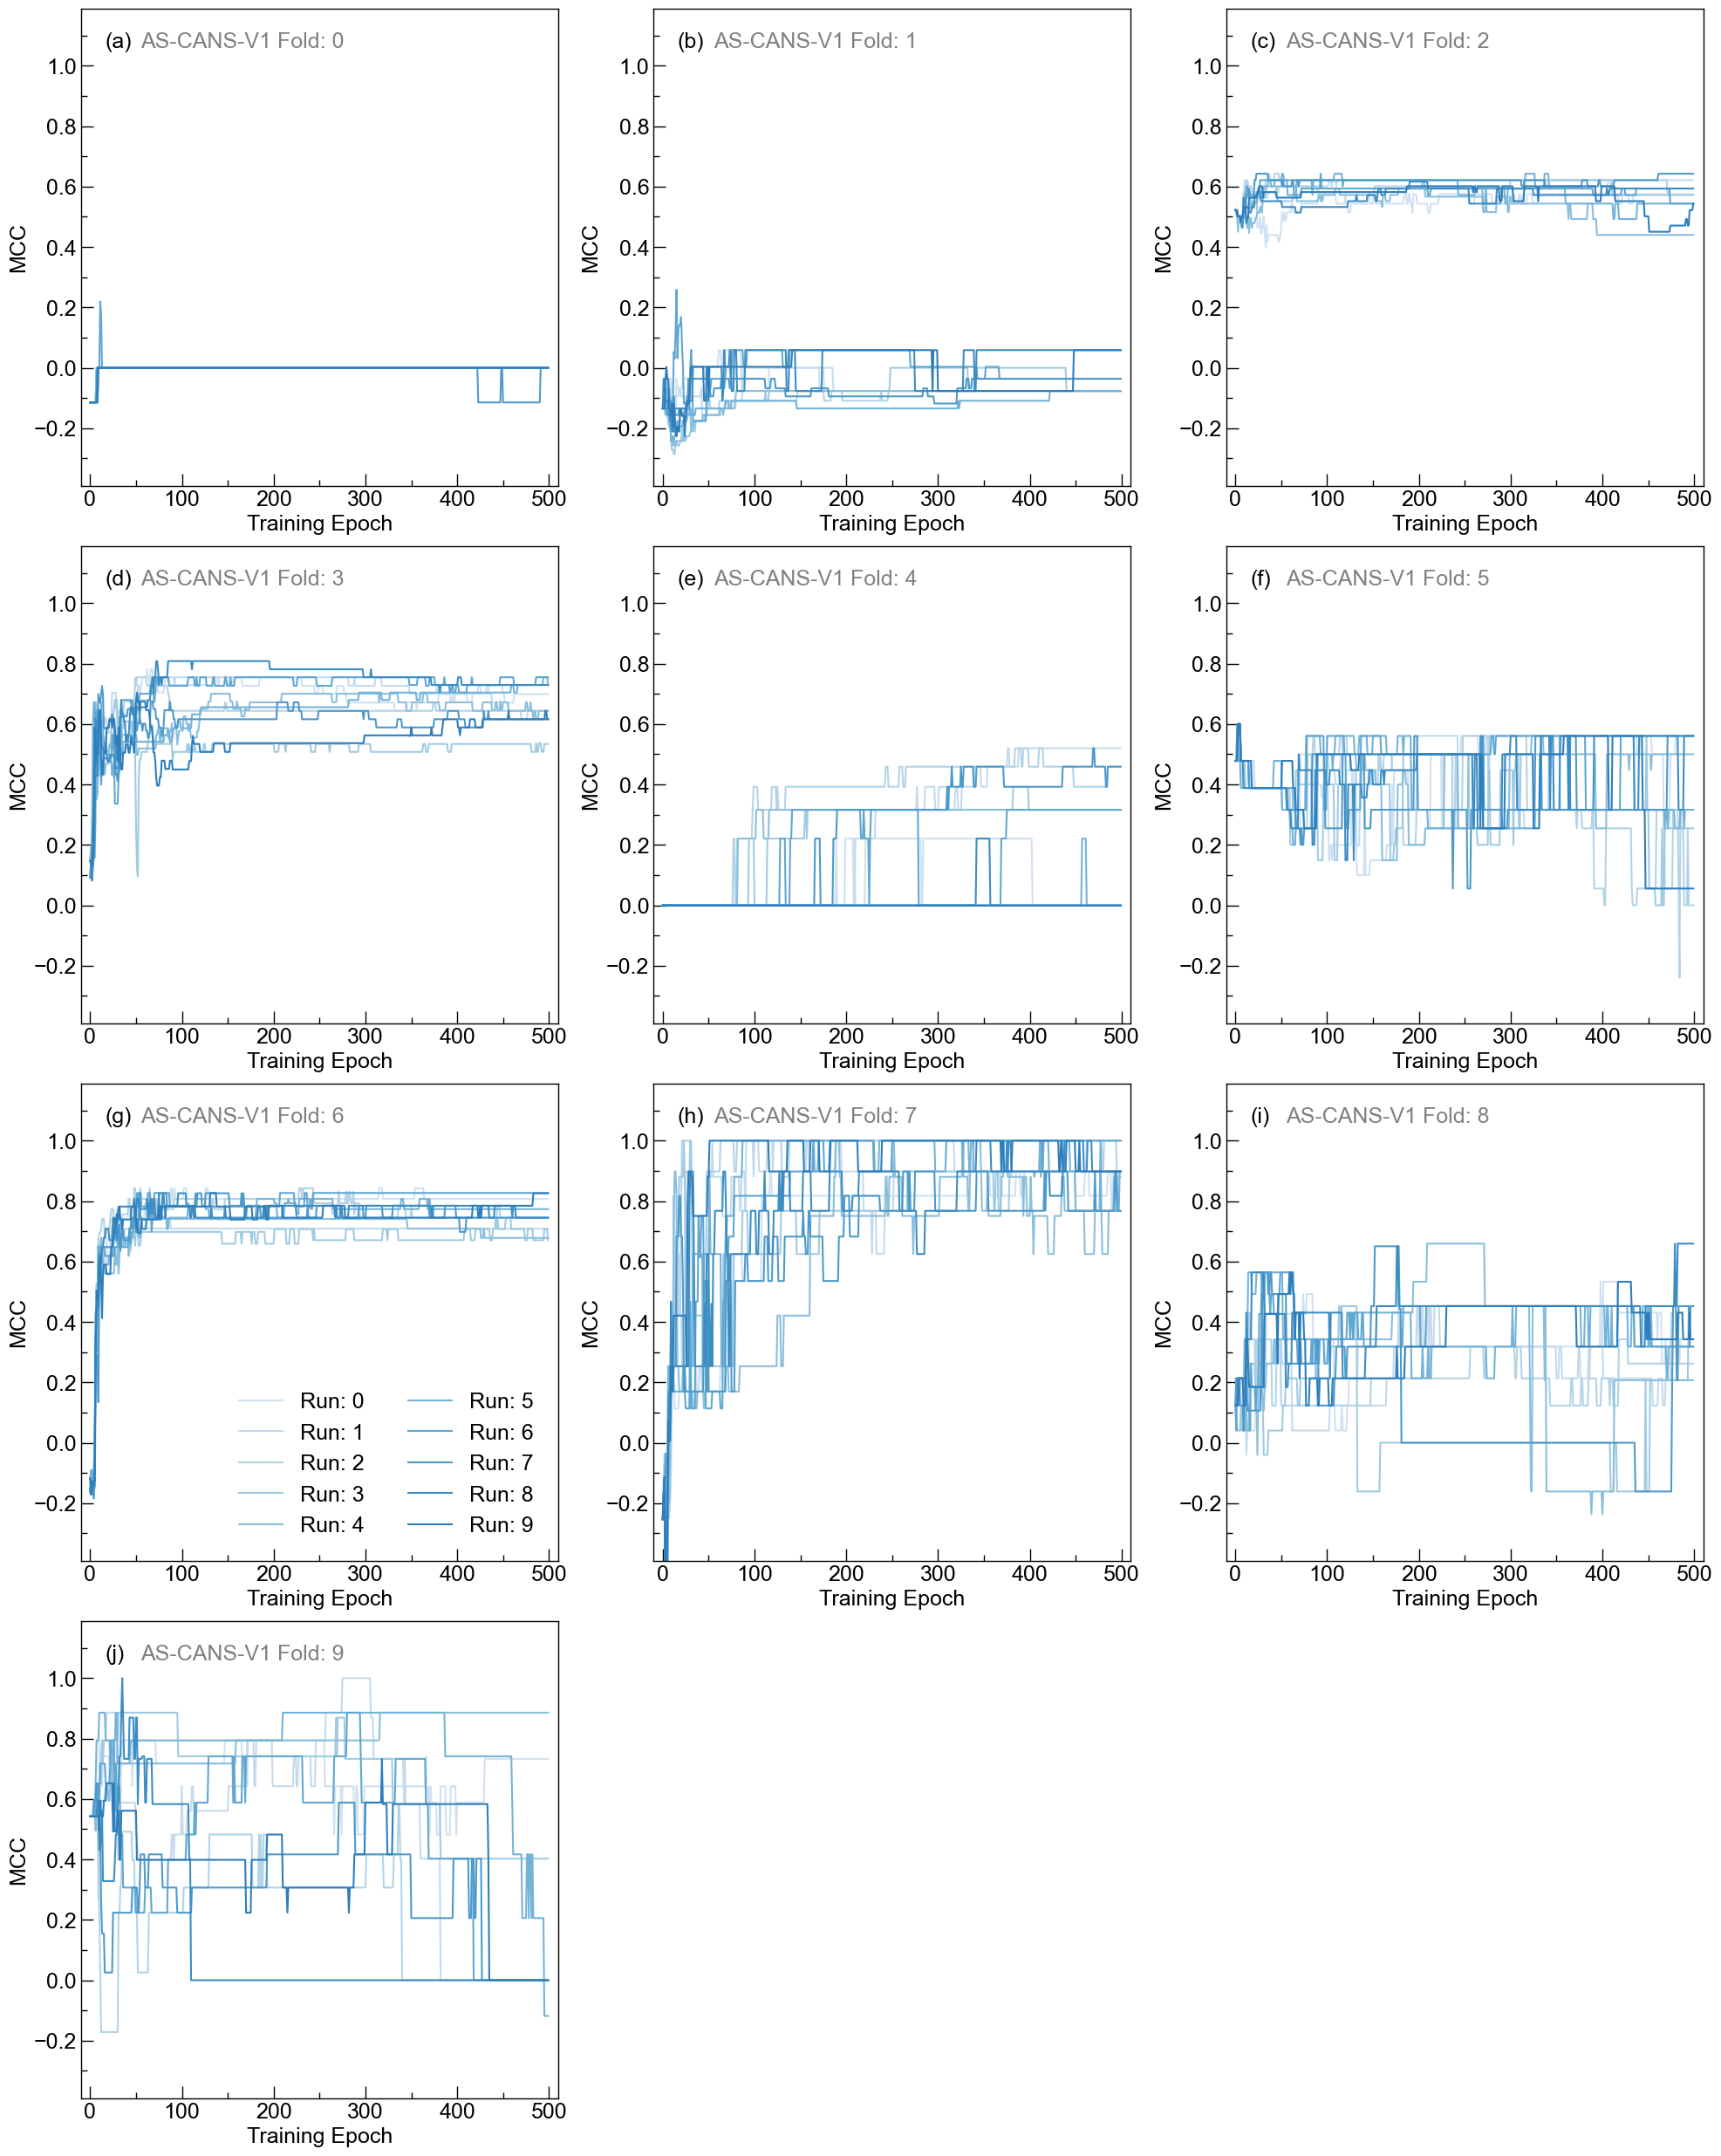

In [55]:
def plot_metric_subplot(ax, plot_label, feature, config_metric, plot_metric, fold, ylim, ylabel, plot_letter, show_legend=False):
    ax.set_xlabel('Training Epoch', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_ylim(ylim)
    ax.set_xlim([-10, 510])
    ax.text(0.05, 0.95, f'({plot_letter})', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)
    ax.text(0.125, 0.95, plot_label, fontsize=18, color='grey', verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)
    ax.set_aspect(np.diff(ax.get_xlim()) / np.diff(ax.get_ylim()))
    
    data_dir = os.path.join(train_val_split_path, f"fold_{fold}", feature)
    top_configs = get_best_hpo_configs_averaged_across_runs(data_dir=data_dir, metric=config_metric, top_n=1, min_epoch=30)
    config = top_configs[0]
    config_dir = os.path.join(data_dir, config)
    
    cmap = plt.colormaps.get_cmap('Blues')
    num_runs = len(os.listdir(config_dir))
    
    for i, run_dir in enumerate(os.listdir(config_dir)):
        history_path = os.path.join(config_dir, run_dir, "history.pkl")
        color = cmap((i / (len(config_dir) // 10)) + 0.2)
        run_data = get_run_history(history_path)
        ax.plot(run_data[plot_metric], label=f'Run: {i}', color=color)
    
    if show_legend:
        ax.legend(loc='lower left', bbox_to_anchor=(0.29, 0.01), fontsize=18, ncol=2, frameon=False)
    
    ax.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k')
    ax.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
    ax.minorticks_on()
    
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)

fig = plt.figure(figsize=(24, 32))
plt.rcParams['font.family'] = 'Arial'

feature = 'structure_simplified_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy_2'
config_metric = 'val_pr_auc'
plot_metric = 'val_mcc'
#ylim = [-0.1, 1.19]
ylim=[-0.39, 1.19]
#ylabel = 'AUC-PR'
ylabel = 'MCC'

gs = GridSpec(4, 3, figure=fig, hspace=0, wspace=0.2)

for fold in range(10):
    show_legend = (fold == 6)  # Show legend only for the first subplot
    plot_letter = chr(97 + fold)  # Generate plot letters 'a', 'b', 'c', ...
    ax = fig.add_subplot(gs[fold // 3, fold % 3])  # Create subplot in the grid
    plot_metric_subplot(ax, f'AS-CANS-V1 Fold: {fold}', feature, config_metric, plot_metric, fold, ylim, ylabel, plot_letter, show_legend=show_legend)

figure_filename = 'AS_CANS_V1_MCC.png'
plt.savefig(figure_filename, dpi=450, bbox_inches='tight')
plt.show()

### Train comparison logistic regression model

In [41]:
set_reproducibility()

atomistic_feature_df = pd.read_pickle(atomistic_feature_path)
scaler = MinMaxScaler()
atomistic_features_normalized = scaler.fit_transform(atomistic_feature_df.iloc[:, 1:])
atomistic_features_normalized_df = pd.DataFrame(atomistic_features_normalized, columns=atomistic_feature_df.columns[1:])
atomistic_features_normalized_df['icsd_collectioncode'] = atomistic_feature_df['icsd_collectioncode']

param_grid = {
    "C": np.logspace(-3, 3, 50),
    "max_iter": [100, 200, 300, 400, 500]
}
results = {}

for fold in os.listdir(train_val_split_path):
    fold_results = []
    
    train_df = pd.read_csv(os.path.join(train_val_split_path, fold, 'train.csv'))
    val_df = pd.read_csv(os.path.join(train_val_split_path, fold, 'val.csv'))
    train_merged = pd.merge(train_df, atomistic_features_normalized_df, on='icsd_collectioncode', how='inner')
    val_merged = pd.merge(val_df, atomistic_features_normalized_df, on='icsd_collectioncode', how='inner')

    X_train = train_merged[['avg_min_li_li_distance', 'avg_min_li_anion_distance', 'avg_num_li_li_bonds', 'avg_ionicity', 'avg_anion_coordination']]
    y_train = train_merged['is_superionic']

    X_val = val_merged[['avg_min_li_li_distance', 'avg_min_li_anion_distance', 'avg_num_li_li_bonds', 'avg_ionicity', 'avg_anion_coordination']]
    y_val = val_merged['is_superionic']

    for params in ParameterGrid(param_grid):
        model = LogisticRegression(C=params['C'], max_iter=params['max_iter'])
        model.fit(X_train, y_train)
    
        y_val_prob = model.predict_proba(X_val)[:, 1]
    
        precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_prob)
        pr_auc_val = auc(recall_val, precision_val)
        mcc_val = matthews_corrcoef(y_val, model.predict(X_val))
        
        result = {
            'C': params['C'],
            'max_iter': params['max_iter'],
            'val_pr_auc': pr_auc_val,
            'val_mcc': mcc_val
        }

        fold_results.append(result)

    results[fold] = fold_results

for fold, fold_results in results.items():
    best_result = max(fold_results, key=lambda x: x['val_pr_auc'])
    print(f"Fold {fold}: Best Params: C={best_result['C']}, max_iter={best_result['max_iter']}")
    print(f"Fold {fold}: Validation PR AUC: {best_result['val_pr_auc']}")
    print(f"Fold {fold}: Validation MCC: {best_result['val_mcc']}")

with open('atomistic_lococv_results.pkl', 'wb') as f:
    pickle.dump(results, f)

C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  

Fold fold_0: Best Params: C=0.655128556859551, max_iter=100
Fold fold_0: Validation PR AUC: 0.5624899800150196
Fold fold_0: Validation MCC: 0.0
Fold fold_1: Best Params: C=33.9322177189533, max_iter=100
Fold fold_1: Validation PR AUC: 0.4448085492088986
Fold fold_1: Validation MCC: 0.11704114719613055
Fold fold_2: Best Params: C=0.001, max_iter=100
Fold fold_2: Validation PR AUC: 0.387326729324327
Fold fold_2: Validation MCC: 0.0
Fold fold_3: Best Params: C=0.28117686979742307, max_iter=100
Fold fold_3: Validation PR AUC: 0.7059017606003584
Fold fold_3: Validation MCC: 0.13045884473731592
Fold fold_4: Best Params: C=0.001, max_iter=100
Fold fold_4: Validation PR AUC: 0.5387081178709786
Fold fold_4: Validation MCC: 0.0
Fold fold_5: Best Params: C=3.5564803062231287, max_iter=100
Fold fold_5: Validation PR AUC: 0.7638888888888888
Fold fold_5: Validation MCC: 0.31622776601683794
Fold fold_6: Best Params: C=0.001, max_iter=100
Fold fold_6: Validation PR AUC: 0.5586268981453185
Fold fold_6:

C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  

In [9]:
results = pd.read_pickle(r'data/atomistic_lococv_results.pkl')

In [10]:
for fold, fold_results in results.items():
    best_result = max(fold_results, key=lambda x: x['val_pr_auc'])
    print(f"Fold {fold}: Best Params: C={best_result['C']}, max_iter={best_result['max_iter']}")
    print(f"Fold {fold}: Validation PR AUC: {best_result['val_pr_auc']}")
    print(f"Fold {fold}: Validation MCC: {best_result['val_mcc']}")

Fold fold_0: Best Params: C=0.655128556859551, max_iter=100
Fold fold_0: Validation PR AUC: 0.5624899800150196
Fold fold_0: Validation MCC: 0.0
Fold fold_1: Best Params: C=33.9322177189533, max_iter=100
Fold fold_1: Validation PR AUC: 0.4448085492088986
Fold fold_1: Validation MCC: 0.11704114719613055
Fold fold_2: Best Params: C=0.001, max_iter=100
Fold fold_2: Validation PR AUC: 0.387326729324327
Fold fold_2: Validation MCC: 0.0
Fold fold_3: Best Params: C=0.28117686979742307, max_iter=100
Fold fold_3: Validation PR AUC: 0.7059017606003584
Fold fold_3: Validation MCC: 0.13045884473731592
Fold fold_4: Best Params: C=0.001, max_iter=100
Fold fold_4: Validation PR AUC: 0.5387081178709786
Fold fold_4: Validation MCC: 0.0
Fold fold_5: Best Params: C=3.5564803062231287, max_iter=100
Fold fold_5: Validation PR AUC: 0.7638888888888888
Fold fold_5: Validation MCC: 0.31622776601683794
Fold fold_6: Best Params: C=0.001, max_iter=100
Fold fold_6: Validation PR AUC: 0.5586268981453185
Fold fold_6: